In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import h5py
import pandas as pd
import scanpy as sc 
import os
import ipdb
import openslide
import numpy as np
from tqdm import tqdm
import torch
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.utils import to_networkx
import networkx as nx
import scanpy as sc
import spatialleiden as sl
import squidpy as sq
from sklearn.cluster import KMeans
import sys
sys.path.append('../../src/')
from mil_models import GNN, GNNConfig, ABMILConfig, ABMIL
from prototype_visualization_utils import get_panther_encoder, visualize_categorical_heatmap, get_mixture_plot, get_default_cmap

/home/fywang/miniconda3/envs/spanther/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# slide_id = "TCGA-69-7760-01Z-00-DX1.7fc295e3-5bfc-4017-801c-491489d0eb34" # LUAD
slide_id = "TCGA-21-A5DI-01Z-00-DX1.E9123261-ADE7-468C-9E9A-334E131FFF97" # LUSC
wsi_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/WSIs"
wsi_path = os.path.join(wsi_dir, f"{slide_id}.svs")
graph_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/extracted_mag20x_patch256/uni_pt_patch_features/WSI_graph"
# graph_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/extracted_mag20x_patch256/uni_pt_patch_features/superpatch_graph"
graph_path = os.path.join(graph_dir, f"{slide_id}.pt")
h5_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/extracted_mag20x_patch256/uni_pt_patch_features/h5_files"
with h5py.File(os.path.join(h5_dir, f"{slide_id}.h5"), "r") as f:
    print(list(f.keys()))
    coords = f["coords"][:]
    features = f["features"][:]
pt_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/extracted_mag20x_patch256/uni_pt_patch_features/pt_files"
pt_path = os.path.join(pt_dir, f"{slide_id}.pt")
pt_data = torch.load(pt_path)
graph_data = torch.load(graph_path)
# slide_prototype_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/extracted_mag20x_patch256/uni_pt_patch_features/cluster_feats"
# slide_prototype_path = os.path.join(slide_prototype_dir, f"{slide_id}.h5ad")
# slide_prototype = sc.read_h5ad(slide_prototype_path)

# connected_dir = "/data1/r20user2/wsi_data/TCGA_NSCLC/extracted_mag20x_patch256/uni_pt_patch_features/superpatch_connected_ot"
# with h5py.File(os.path.join(connected_dir, f"{slide_id}.h5"), "r") as f:
#     print(list(f.keys()))
#     connected_coords = f["coords"][:]
#     connected_features = f["features"][:]

['coords', 'features']


/tmp/ipykernel_983655/120966305.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pt_data = torch.load(pt_path)
/tmp/ipykernel_983655/120966305.py:16: FutureWarning: You 

In [3]:
config = GNNConfig()
config.in_dim = 1024
model = GNN(config, mode="classification")
# ckpt = "/home/fywang/Documents/SPANTHER/src/results/NSCLC_classification::GNN_default::uni_pt_patch_features/NSCLC_classification/k=0/NSCLC::GNN_default::superpatch_graph/NSCLC::GNN_default::superpatch_graph::25-03-08-21-44-56/s_checkpoint.pth"
ckpt = "/home/fywang/Documents/SPANTHER/src/results/NSCLC_classification::GNN_default::uni_pt_patch_features/NSCLC_classification/k=0/NSCLC::GNN_default::WSI_graph/NSCLC::GNN_default::WSI_graph::25-03-09-20-07-28/s_checkpoint.pth"
model.load_state_dict(torch.load(ckpt)["model"])

# config = ABMILConfig()
# config.in_dim = 1024
# config.gate = True
# config.embed_dim = 512
# config.attn_dim = 384
# config.n_fc_layers = 1
# config.dropout = 0.25

# model = ABMIL(config, mode="classification")
# ckpt = "/home/fywang/Documents/SPANTHER/src/results/NSCLC_classification/NSCLC_classification::ABMIL_default/NSCLC_classification/k=0/NSCLC::ABMIL_default::h5_files/NSCLC::ABMIL_default::h5_files::25-03-17-11-35-06/s_checkpoint.pth"
# model.load_state_dict(torch.load(ckpt)["model"])

/tmp/ipykernel_983655/2281340290.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt)["model"])


<All keys matched successfully>

In [4]:
x, edge_index = graph_data.x, graph_data.edge_index
x = model.preprocess(x)
if model.num_layers > 0:
    for conv in model.convs_list:
        x = conv(x, edge_index)
else:
    # in this case, it is identity
    x = model.convs_list(x)

A, x = model.attention_net(x)
A = torch.transpose(A, 0, 1)
A = F.softmax(A, dim=1)
x = torch.mm(A, x)

logits = model.fc(x)
print(logits)


# h, A = model.forward_attention(pt_data)

tensor([[-1.58,  2.15]], grad_fn=<AddmmBackward0>)


vis_level: 2
4760 3955
16.000505689001265


(-0.5, 4759.5, 3954.5, -0.5)

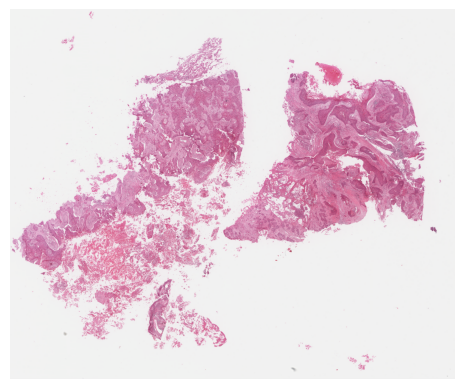

In [5]:
# plot topk subbgraphs and whole WSI
wsi = openslide.open_slide(wsi_path)
downscale = 32
vis_level = wsi.get_best_level_for_downsample(downscale)
print(f"vis_level: {vis_level}")
w, h = wsi.level_dimensions[vis_level]
print(w, h)
downsamples = wsi.level_downsamples[vis_level]
print(downsamples)

patch_size = 512
vis_patch_size = int(patch_size / downsamples)
whole_wsi = np.array(wsi.read_region((0, 0), level=vis_level, size=(w, h)).convert("RGB"))
plt.imshow(whole_wsi)
plt.axis("off")
# plt.savefig(f"WSI_{slide_id}.pdf", bbox_inches="tight")

In [6]:
# seed = 42

# adata = sc.AnnData(features)
# adata.obsm["spatial"] = coords

# sc.pp.pca(adata, n_comps=64, random_state=seed)
# sc.pp.neighbors(adata, random_state=seed)
# sq.gr.spatial_neighbors(adata, coord_type="generic", n_neighs=8)
# adata.obsp["spatial_connectivities"] = sl.distance2connectivity(
#     adata.obsp["spatial_distances"]
# )
# sc.tl.leiden(adata, directed=False, random_state=seed)
# sl.spatialleiden(adata, layer_ratio=1.8, directed=(False, True), seed=seed)

In [7]:
# ### Visualize the categorical heatmap and the GMM mixtures
# cat_map = visualize_categorical_heatmap(
#     wsi,
#     coords, 
#     adata.obs["spatialleiden"].to_numpy().astype(int), 
#     label2color_dict=get_default_cmap(32),
#     vis_level=wsi.get_best_level_for_downsample(32),
#     patch_size=(patch_size, patch_size),
#     alpha=0.4,
# )

# resized_cat_map = cat_map.resize((cat_map.width, cat_map.height))
# # resized_cat_map.save(f"Spatial_Leiden_cluster_{slide_id}.pdf")
# display(resized_cat_map)

In [8]:
# cluster_labels = adata.obs["spatialleiden"].to_numpy().astype(int)

In [9]:
# cluster_labels.shape

In [10]:
# cluster_labels

In [11]:
# np.unique(cluster_labels)

In [12]:
A[0]

tensor([9.68e-06, 7.16e-06, 6.01e-06, 7.34e-06, 7.41e-06, 7.48e-06, 6.01e-06,
        5.08e-06, 4.64e-06, 5.21e-06, 6.51e-06, 7.34e-06, 7.41e-06, 6.21e-06,
        5.38e-06, 4.68e-06, 4.42e-06, 4.76e-06, 7.40e-06, 6.60e-06, 5.35e-06,
        4.46e-06, 4.06e-06, 3.92e-06, 3.92e-06, 3.91e-06, 7.64e-06, 6.83e-06,
        5.31e-06, 4.16e-06, 3.65e-06, 3.57e-06, 3.86e-06, 4.42e-06, 7.34e-06,
        6.44e-06, 4.98e-06, 3.79e-06, 3.31e-06, 3.39e-06, 4.00e-06, 4.94e-06,
        6.35e-06, 1.44e-05, 5.59e-06, 4.33e-06, 3.43e-06, 3.14e-06, 3.37e-06,
        4.09e-06, 5.18e-06, 6.86e-06, 1.02e-05, 1.44e-05, 1.76e-05, 2.04e-05,
        3.71e-06, 3.31e-06, 3.23e-06, 3.54e-06, 4.14e-06, 5.03e-06, 6.68e-06,
        1.01e-05, 1.43e-05, 1.75e-05, 2.04e-05, 3.45e-06, 3.50e-06, 3.59e-06,
        3.81e-06, 4.12e-06, 4.56e-06, 5.53e-06, 1.41e-05, 4.09e-06, 4.21e-06,
        4.20e-06, 4.20e-06, 4.26e-06, 4.31e-06, 4.83e-06, 4.75e-06, 4.59e-06,
        4.39e-06, 4.31e-06, 4.53e-06, 4.66e-06, 5.06e-06, 4.74e-

In [13]:
# heatmap = np.zeros(len(cluster_labels))
# for i in np.unique(cluster_labels):
#     # print(i)
#     indices = np.where(cluster_labels == i)[0]
#     # print(indices.shape)
#     # print(heatmap[indices])
#     heatmap[indices] = A[0][i].item()
# print(heatmap)

In [14]:
# heatmap.shape

In [15]:
# heatmap = wsi.visHeatmap(scores=scores, coords=coords, vis_level==wsi.get_best_level_for_downsample(32))

In [16]:
# from WholeSlideImage import WholeSlideImage
# wsi_object = WholeSlideImage(wsi_path)

In [17]:
# def drawHeatmap(scores, coords, slide_path=None, wsi_object=None, vis_level = -1, **kwargs):
#     if wsi_object is None:
#         wsi_object = WholeSlideImage(slide_path)
#         print(wsi_object.name)
    
#     wsi = wsi_object.getOpenSlide()
#     if vis_level < 0:
#         vis_level = wsi.get_best_level_for_downsample(32)
    
#     heatmap = wsi_object.visHeatmap(scores=scores, coords=coords, vis_level=vis_level, **kwargs)
#     return heatmap

In [18]:
heatmap = A[0].detach().cpu().numpy()
norm_heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
print(norm_heatmap.max())
print(norm_heatmap.min())  

1.0
0.0


In [19]:
# plot_heatmap = drawHeatmap(norm_heatmap, coords, wsi_path, wsi_object=wsi_object,  
#                             cmap="jet", alpha=0.4, 
#                             binarize=False, 
#                             blank_canvas=False,
#                             segment=False,
#                             thresh=-1,  patch_size = 512)

In [20]:
whole_wsi.shape

(3955, 4760, 3)

In [21]:
viz_heatmap = np.zeros((whole_wsi.shape[0], whole_wsi.shape[1]))
viz_patch_size = int(512 // downsamples)
for coord, attn in zip(coords, norm_heatmap):
    viz_coord = coord // downsamples
    # print(viz_coord)
    viz_heatmap[int(viz_coord[0]):int(viz_coord[0])+viz_patch_size, int(viz_coord[1]):int(viz_coord[1])+viz_patch_size] = attn

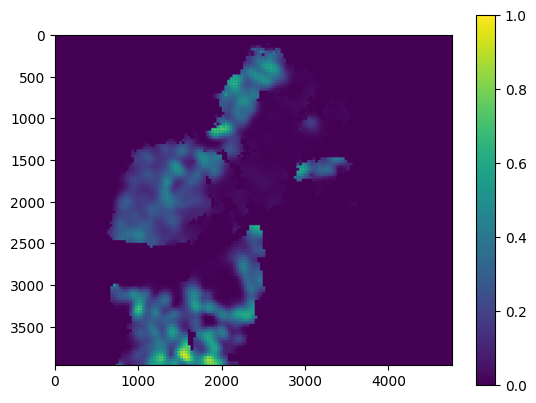

In [22]:
plt.imshow(viz_heatmap)
plt.colorbar()

100%|██████████| 6194/6194 [00:00<00:00, 15327.64it/s]
/tmp/ipykernel_983655/1108732733.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap('jet') # 'plasma' or 'viridis'


Text(0, 0.5, 'Attention Weight')

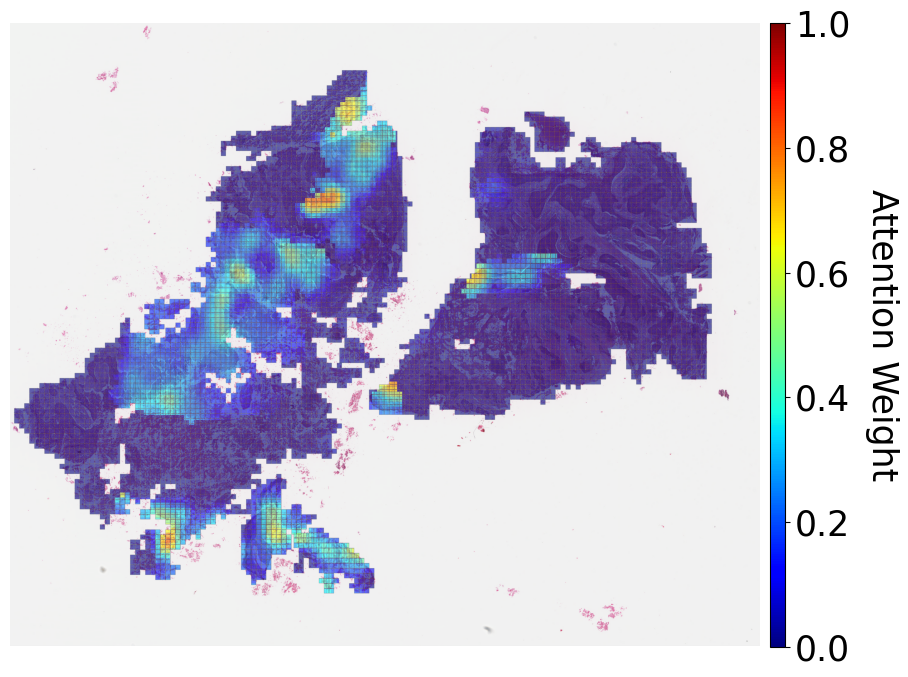

In [25]:
from PIL import Image, ImageOps
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

color_heatmap = cv2.applyColorMap((viz_heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
color_heatmap = cv2.cvtColor(color_heatmap, cv2.COLOR_BGR2RGB)
# ax.imshow(color_heatmap)
alpha = 0.4

img = whole_wsi.copy()
for idx in tqdm(range(len(coords))):
    coord = coords[idx]
    coord = (coord // downsamples).astype(int)
    img_block = img[coord[1]:coord[1]+viz_patch_size, coord[0]:coord[0]+viz_patch_size].copy()
    color_block = color_heatmap[coord[1]:coord[1]+viz_patch_size, coord[0]:coord[0]+viz_patch_size].copy()
    blended_block = cv2.addWeighted(img_block, alpha, color_block, 1 - alpha, 0)
    blended_block = np.array(ImageOps.expand(Image.fromarray(blended_block), border=1, fill=(50,50,50)).resize((img_block.shape[1], img_block.shape[0])))
    img[coord[1]:coord[1]+viz_patch_size, coord[0]:coord[0]+viz_patch_size] = blended_block

im = ax.imshow(img)
ax.set_axis_off()

colormap = plt.cm.get_cmap('jet') # 'plasma' or 'viridis'
sm = plt.cm.ScalarMappable(cmap=colormap)
sm.set_clim(vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.1)
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=25)
cbar.ax.set_ylabel('Attention Weight', rotation=270, fontsize=25, labelpad=35)
# # add colorbar
# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im, cax=cax, orientation='vertical', cmap="jet")